In [115]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('..')
from Dynearthsol import Dynearthsol

In [116]:
# Parameters
perm = 1.02e-12  # Permeability (m^2)
rho_f = 1000  # Density of fluid (kg/m^3)
eta_f = 1.002e-3  # Dynamic viscosity of fluid (Pa.s)
grav = 10  # Gravitational acceleration (m/s^2)
gamma_w = grav * rho_f  # Unit weight of water (N/m^3)
cond = perm * gamma_w / eta_f  # Hydraulic conductivity (m/s)

phi = 0.3  # Porosity
beta_w = 1/2.17e9  # Compressibility of water (1/Pa)
K_bulk = 1e7  # Bulk modulus (Pa)
mu = 1e7  # Shear modulus (Pa)

alpha_c = 1.0  # Biot coefficient
H = 10  # Column height (m)

# Calculate Lamé's first parameter using bulk and shear modulus
lambda_lame = K_bulk - (2/3) * mu

sigma_zz = -1e5 

Cv = ((phi * beta_w + alpha_c * (alpha_c + phi - phi*alpha_c) / (lambda_lame + 2 * mu)) ** -1) * (cond / gamma_w)

# Time points
day = 86400
year = 86400*365.25

time_points = np.linspace(0, 10000, 101)  # Time from 0 to 5 days
z = 0  # Depth at the bottom (m)

# Number of terms for summation
num_terms = 1000

# Calculate the coefficient for the summation
skmpton = (phi * beta_w * (lambda_lame + 2 * mu) / (alpha_c + phi - phi*alpha_c) + alpha_c) ** -1
#coeff = - sigma_zz * skmpton
coeff = - sigma_zz

# Initialize P_ex over time for the bottom point
P_ex_time = []

ic = 10*1000*10
# Compute P_ex over time for the bottom point
for t in time_points:
    P_ex = 0
    for j in range(num_terms):
        term = (4 / np.pi) * ((-1) ** j) / (2 * j + 1)
        cos_term = np.cos((2 * j + 1) * np.pi * z / (2 * H))
        exp_term = np.exp(-((2 * j + 1) * np.pi / 2) ** 2 * Cv * t / H ** 2)
        P_ex += term * cos_term * exp_term
    P_ex *= coeff 
    P_ex_time.append(P_ex * 1e-5)

print("consolidation coeff:", Cv, "loading stress MPa:", (-sigma_zz + ic)/1e6, skmpton)



consolidation coeff: 0.023676120427954382 loading stress MPa: 0.2 0.9967845659163987


0.9967055472862429


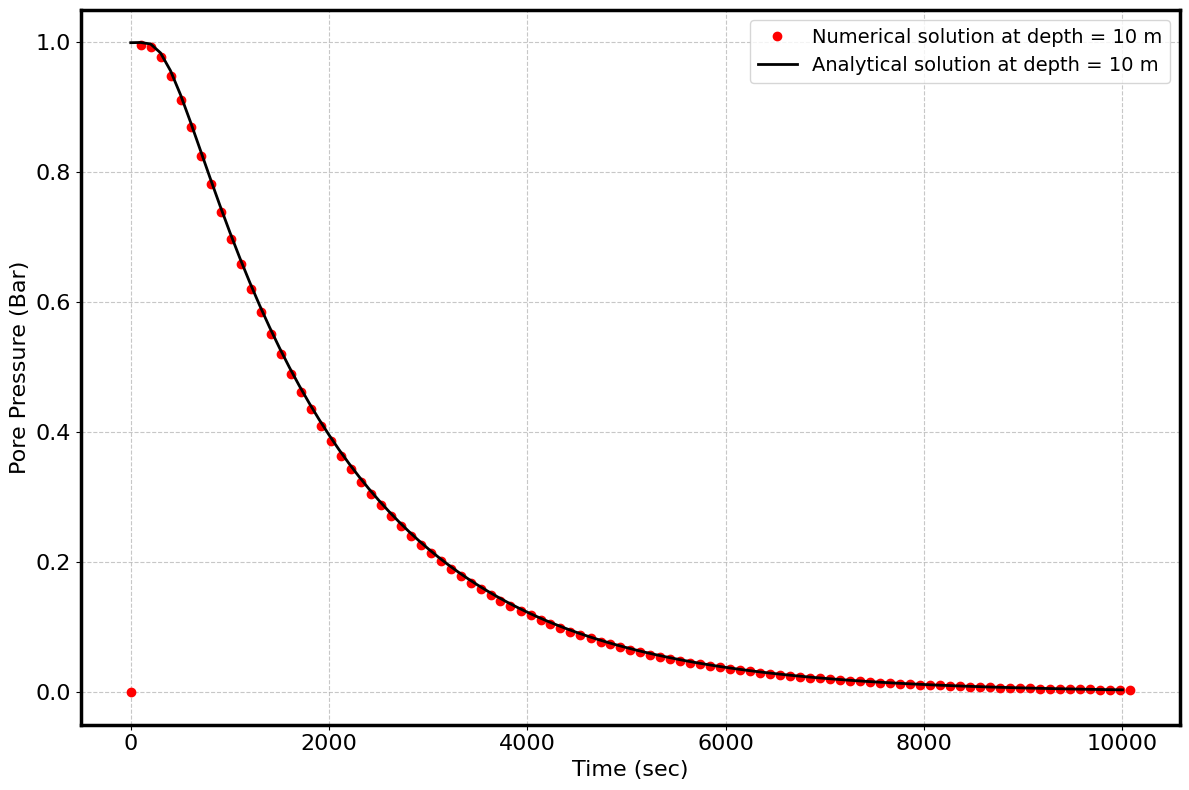

In [117]:
# Constants
ATMOSPHERIC_PRESSURE = 0.0  # Atmospheric pressure in appropriate units
GRAVITY = 10  # Acceleration due to gravity (m/s^2)
FLUID_DENSITY = 1000  # Fluid density (kg/m^3)
GAMMA_W = GRAVITY * FLUID_DENSITY  # Specific weight of water (N/m^3)
dim = 3
# Model names
MODEL_NAMES = [
    "terzaghi"
]

# Function to read time steps and times from the info file
def read_time_steps(filename):
    data = np.loadtxt(filename, usecols=(0, 2))
    time_steps = data[:, 0].astype(int)
    times = data[:, 1]
    return time_steps, times

if(dim == 3):
    # Function to perform numerical calculations for each time step
    def numerical(num_steps, model_name):
        des = Dynearthsol(model_name)
        pore_pressures = np.zeros(num_steps, dtype=float)
        for time_step in range(num_steps):
            pore_pressure = des.read_field(time_step, 'pore pressure')
            coordinates = des.read_field(time_step, 'coordinate')
            pore_pressures[time_step] = pore_pressure[0] - ATMOSPHERIC_PRESSURE + GAMMA_W * coordinates[0, 2]
        return pore_pressures
else:
    # Function to perform numerical calculations for each time step
    def numerical(num_steps, model_name):
        des = Dynearthsol(model_name)
        pore_pressures = np.zeros(num_steps, dtype=float)
        for time_step in range(num_steps):
            pore_pressure = des.read_field(time_step, 'pore pressure')
            coordinates = des.read_field(time_step, 'coordinate')
            pore_pressures[time_step] = pore_pressure[0] - ATMOSPHERIC_PRESSURE + GAMMA_W * coordinates[0, 1]
        return pore_pressures
    
# Read time steps and numerical times from the info file of one of the models
time_steps, times = read_time_steps(MODEL_NAMES[0] + '.info')
num_steps = len(time_steps)


# Run numerical calculations for all models
pore_pressures = [numerical(num_steps, model_name) for model_name in MODEL_NAMES]

# Plotting (PT refers to pseudo-transient iterations)
plt.figure(figsize=(12, 8))

print(pore_pressures[0][1]/1e5)
# Plot numerical solution
plt.plot(times, pore_pressures[0] * 1e-5, 'o', color='red', markersize=6, linewidth=2, label=f'Numerical solution at depth = {H} m',)

# Plot analytical solution
plt.plot(time_points, P_ex_time, label=f'Analytical solution at depth = {H} m', color='k', linestyle='-', linewidth=2)

# Customize plot aesthetics
plt.xlabel('Time (sec)', fontsize=16)
plt.ylabel('Pore Pressure (Bar)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add a thicker box by adjusting the linewidth for all spines
plt.gca().spines['top'].set_linewidth(2.5)
plt.gca().spines['right'].set_linewidth(2.5)
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)

# Grid, legend, and layout improvements
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=14)
plt.tight_layout()

# Show plot
plt.show()